In [1]:
using Pkg, Plots
using LinearAlgebra, Distributions, Statistics
using Random

In [3]:
Random.seed!(420)

# Simulate random data
t = collect(range(20, 65, length = 100))
measurements = ((t.^4 .+ 6e5 .* sin.(t) .+ 6.5e5 * cos.(t)) + rand(Normal(5e5, 2.3e5), 100))
measurements /= maximum(measurements);

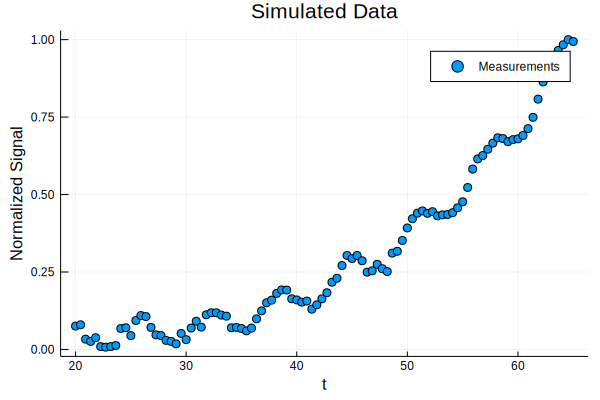

In [7]:
scatter(t, measurements, title = "Simulated Data", xlabel = "t", ylabel = "Normalized Signal",
        label = "Measurements")

In [8]:
mutable struct KalmanFilter
    
    X0::Array{Float64}
    U::Array{Float64}
    P_::Array{Float64}
    F_::Array{Float64}
    B_::Array{Float64}
    H_::Array{Float64}
    Q_::Array{Float64}
    R_::Array{Float64}
    
    z::Float64
    measurements_::Array{Float64}
    
    function KalmanFilter(measurements_::Array{Float64},
                          X0::Array{Float64}, U::Array{Float64}, P_::Array{Float64}, F_::Array{Float64},
                          B_::Array{Float64}, H_::Array{Float64}, Q_::Array{Float64}, R_::Array{Float64})
            
             
             pred = zeros(length(measurements))
        
             for (i, z) in enumerate(measurements_)
            
                pred[i] = (H_ * predict(F_, B_, U, H_, Q_, R_, P_,X0))[1]
                update(z, F_, B_, U, H_, Q_, R_, P_, X0)
            
             end
        
        return pred
        
     end
    
end



function predict(F, B, u, H, Q, R, P, x0)
    
    x0[:] = F * x0 + B * u
    P[:] = F * P * transpose(F) + Q
    
    return  x0
    
end



function update(z, F, B, u, H, Q, R, P, x0)

    y_tilde = z .- (H * x0)
    S = H * P * transpose(H) + R
    K = (P * transpose(H)) * inv(S)
    
    I_ = Matrix(1.0I, 3, 3)
    
    x0[:] = x0 + (K * y_tilde)
    P[:] = (I - (K * H)) * P

end

update (generic function with 1 method)

In [9]:
# Kalman Filter Related Variables
δt = 1.0/20

x0 = [0.0; 0.0; 0.0]

u =  [0.0; 0.0; 0.0]

P =  Matrix(1.0I, 3, 3)

F = [1.0 δt 0.0;
     0.0 1.0 δt;
     0.0 0.0 1.0]

B = zeros(3, 3)

H = [1.0 0.0 0.0]

Q = [0.05 0.05 0.0; 
     0.05 0.05 0.0; 
     0.0 0.0 0.0]

R = [0.1]

# Kalman filter predictions
kf = KalmanFilter(measurements, x0, u, P, F, B, H, Q, R);

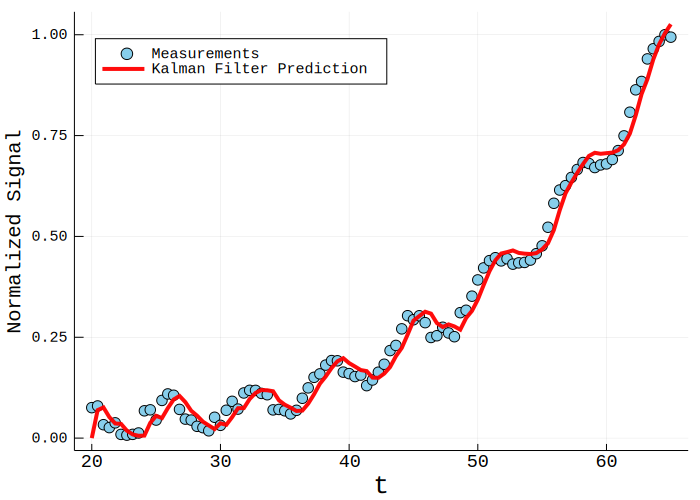

In [10]:
scatter(t, measurements, markersize = 5.5, label = "Measurements", size = (700, 500),
        markerstrokecolor = :black, markercolor = :skyblue , legend = :topleft)

plot!(t, kf, lw = 4, alpha = 0.95, label = "Kalman Filter Prediction", color = :red, 
      xlabel = "t", xtickfont = font(10, "Courier"), xguidefontsize = 14,
      ylabel = "Normalized Signal")